This python notebook shows how to use the library.
These following lines import minimum necessary things, and declare variables

In [2]:
import os
from datetime import datetime
from functools import partial

import jax
import jax.experimental.optimizers as jopt
import jax.numpy as np
import jax.random as jrandom
import matplotlib.pyplot as plt
from jax import jit, value_and_grad
from tqdm import trange

from DeepSPDE import Fourier, LMatrixGenerator, RandomGenerator
from Measurements import DenoisingOneD, OneDSampleSignalShape
from Optimizers import OptimizerType, adahessian, hessian_free, value_grad_and_hessian
from utils import metric, set_plot
from utils.loss_function_and_support import from_complex_w_halfs_to_ravelled_reals, from_two_reals_ravelled_to_complex, \
    loss, non_analytical_mean_and_std, output_fun
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"

In [3]:
fig_size, lw, marker_size = set_plot(use_latex=True)

In [309]:
optimizer = OptimizerType.ADA_HESSIAN
fourier_basis_number = 64
fourier_target_number = 128
measurement_samples_number = 1
measurement_variance = 0.01
n_prior_layers = 2
use_randomized_initialization = False
signal_shape = OneDSampleSignalShape.SMOOTH_DISCONTINUOUS
momentum = 0.1
cg_max_iter = 100
n_samples = 1000
kappa0 = 5e2
n_steps = 10000
use_soft_max = True
use_gnm=False
step_scale = 1e-5
if n_prior_layers>1:
    step_scale = 1e-3
    momentum = 0.1
    kappa0 = 1e1

if optimizer == OptimizerType.HESSIAN_FREE:
    kappa0 = 1e0#1e0
    n_steps=100
    step_scale = 1e0
    use_soft_max = False
elif optimizer == OptimizerType.ADA_HESSIAN:
    step_scale = 1e-1
    adahessian_b1 = 0.9
    adahessian_b2 = 0.999
    if n_prior_layers>1:
        kappa0 = 1e1
        step_scale = 1e-1
        adahessian_b1 = 0.01
        adahessian_b2 = 0.01
elif optimizer == OptimizerType.ADAM:
    if n_prior_layers==1:
        kappa = 5e2
        step_scale = 1e-3
        adam_b1 = 0.99
        adam_b2 = 0.01
    else:
        kappa = 1e0
        step_scale = 1e-2
        adam_b1 = 0.1
        adam_b2 = 0.999

In [310]:
f = Fourier(fourier_basis_number, fourier_target_number, 1)
dod = DenoisingOneD(num_points=2 * f.target_basis_number - 1, basis_number=f.basis_number,
                    std_dev=np.sqrt(measurement_variance),
                    number_of_sample=measurement_samples_number,
                    signal_shape=signal_shape)

if use_soft_max:
    kappa_fun = lambda x: np.log(np.exp(x) + 1)
    l_matrix = LMatrixGenerator(f, kappa0=kappa0, kappa_fun=kappa_fun)
else:
    l_matrix = LMatrixGenerator(f, kappa0=kappa0)

JaxDeepSPDE/Measurements/denoising_one_d.py:182: RuntimeWarning: divide by zero encountered in double_scalars
  ground_truth_signal[i] = onp.exp(4 - 1 / (2 * t[i] - 4 * t[i] ** 2))


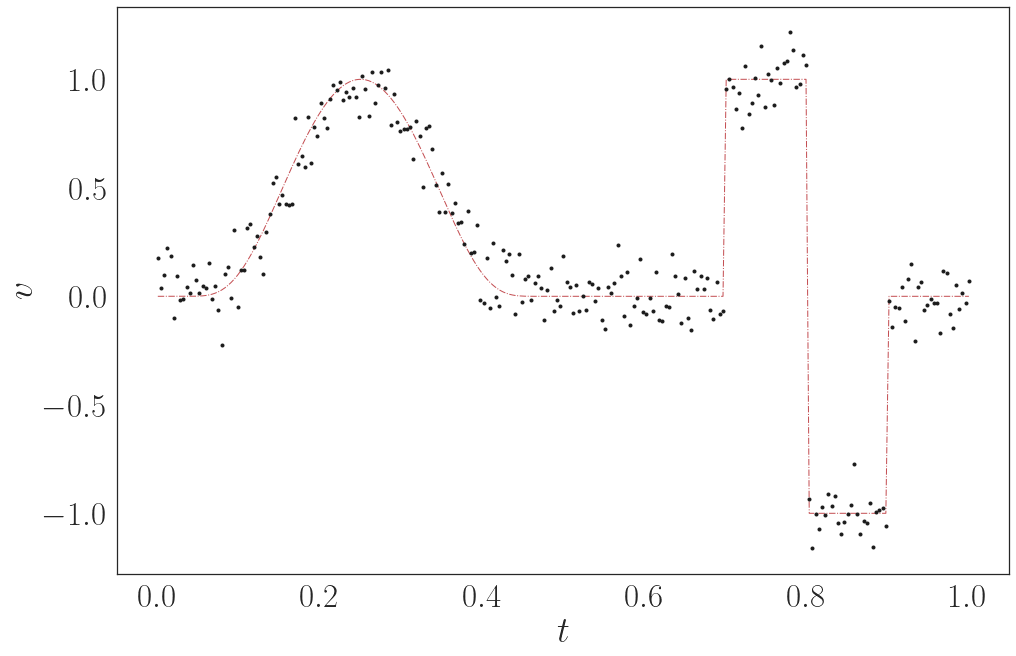

In [311]:
y_ = dod.measure()
dod.t.shape
plt.figure(figsize=fig_size)
plt.plot(dod.t,dod.ground_truth,'-.r',linewidth=lw)
plt.plot(dod.t,y_,'.k', markersize = marker_size,linewidth=lw)
plt.ylabel('$v$')
plt.xlabel('$t$')
plt.tight_layout()

Set how many prior layers, and initial `w_halfs` and `sigmas`. Then draw a random `y` vector.

In [312]:
identity = np.eye(2 * f.basis_number - 1)
identity_m = np.eye(dod.num_points)
meas_samples = dod.measure()
normalized_meas_samples = np.asarray(meas_samples, dtype=np.float32) / dod.std_dev
h_matrix = np.asarray(dod.measurement_matrix, dtype=np.complex64) / dod.std_dev
h_conj_t = h_matrix.conj().T

@partial(jit, static_argnums=(1,))
def wrapped_loss(whalfs_real, whalfs_shape, sigmas_in, y):
    w_halfs_in = from_two_reals_ravelled_to_complex(whalfs_real, whalfs_shape)
    return loss(w_halfs_in, sigmas_in, y, h_conj_t, identity_m, l_matrix)

@partial(jit, static_argnums=(2,))
def wrapped_output_fun(sigmas_in, whalfs_real, whalfs_shape, y):
    w_halfs_in = from_two_reals_ravelled_to_complex(whalfs_real, whalfs_shape)
    return output_fun(w_halfs_in, sigmas_in, y, h_conj_t, identity_m, l_matrix)

rg = RandomGenerator(f.basis_number, f.dimension)
picked_whalfs = np.zeros((n_prior_layers, f.basis_number), dtype=np.complex64)
if optimizer in [OptimizerType.HESSIAN_FREE]:
    picked_whalfs = rg.construct_w_half(n_prior_layers)
picked_log_sigmas = np.zeros(n_prior_layers + 1)
sigmas = np.ones(n_prior_layers + 1)

In [313]:
if use_randomized_initialization:
    print('Use a randomized initial condition ...')
    picked_val = np.inf
    loss_val = np.nan
    picked_log_sigmas = 0
    picked_whalfs = 0

    picked_log_sigmas = np.log(sigmas)
    prngkey = jrandom.PRNGKey(random_seed)
    w_halfs_many = rg.construct_w_half(n_prior_layers * random_loop_length)
    w_halfs_many = w_halfs_many.reshape((random_loop_length, n_prior_layers, l_matrix.fourier.basis_number))
    prngkey, subkeys = jrandom.split(prngkey)
    log_sigmas = jrandom.normal(subkeys, shape=(random_loop_length, n_prior_layers + 1))
    for i in trange(random_loop_length):
        sigmas = np.exp(picked_log_sigmas + log_sigmas[i])
        w_halfs = picked_whalfs + w_halfs_many[i]
        loss_val = loss(w_halfs, sigmas,
                        normalized_meas_samples,
                        h_conj_t, identity_m, l_matrix).block_until_ready()  # test with first measurement

        if loss_val < 0.:  # below zero seems an invalid value
            continue

        if loss_val < picked_val:
            picked_val = loss_val
            picked_whalfs = w_halfs
            w_halfs_real, w_halfs_shape = from_complex_w_halfs_to_ravelled_reals(w_halfs)
            state_init = np.concatenate((sigmas, w_halfs_real))
            print('update picked_val to {}'.format(picked_val))
        if picked_val < required_max_loss_val:
            break

In [314]:
if optimizer in [OptimizerType.HESSIAN_FREE, OptimizerType.ADA_HESSIAN]:
    w_halfs_real, w_halfs_shape = from_complex_w_halfs_to_ravelled_reals(picked_whalfs)
    state_init = w_halfs_real
    if optimizer == OptimizerType.ADA_HESSIAN:
        opt = adahessian(step_size=step_scale,b1=adahessian_b1,b2=adahessian_b2)
        rng = jax.random.PRNGKey(1)
        opt_state = opt.init_fn(state_init)

else:
    state_init = (picked_whalfs.copy(),)
    if optimizer == OptimizerType.ADAM:
        opt = jopt.adam(step_size=step_scale,b1=adam_b1,b2=adam_b2)
        opt_state = opt.init_fn(state_init)
    elif optimizer == OptimizerType.RMSPROP:
        opt = jopt.rmsprop(step_size=step_scale)
        opt_state = opt.init_fn(state_init)
    elif optimizer == OptimizerType.RMSPROP_MOMENTUM:
        opt = jopt.rmsprop_momentum(step_size=step_scale, momentum=momentum)
        opt_state = opt.init_fn(state_init)

In [315]:
simulation_time_string = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
simulation_id = simulation_time_string + '_' + dod.signal_shape.name + '_n_prior_layers' + str(n_prior_layers)

loss_val_list = []
nu_val_list = []
v_mean_list = []
v_std_list = []
kappa_list = []
end_state_list = []

In [316]:
y = normalized_meas_samples
if optimizer in [OptimizerType.HESSIAN_FREE, OptimizerType.ADA_HESSIAN]:
    def re_wrapped_loss(state_real, whalfs_shape=(2, n_prior_layers, f.basis_number),
                        num_sigmas=n_prior_layers + 1):
        sigmas_in = np.ones(num_sigmas)
        w_real = state_real
        return wrapped_loss(w_real, whalfs_shape, sigmas_in, y)

    def re_wrapped_output_fun(state_real, whalfs_shape=(2, n_prior_layers, f.basis_number),
                              num_sigmas=n_prior_layers + 1):
        sigmas_in = np.ones(num_sigmas)
        w_real = state_real
        return wrapped_output_fun(sigmas_in, w_real, whalfs_shape, y)

    if use_gnm:
        fun = re_wrapped_output_fun
    else:
        fun = re_wrapped_loss

    if optimizer == OptimizerType.HESSIAN_FREE:
        state_hist, nu_hist, value_hist = hessian_free(fun, state_init, n_steps=n_steps,
                                                       use_gnm=use_gnm,
                                                       cg_max_iter=cg_max_iter,
                                                       learning_rate=step_scale)
        w_halfs_real = state_hist[-1, :]
        end_state_list.append(w_halfs_real)

    # ADA_HESSIAN
    else:
        def optimizer_step(step, opt_state, rng):
            val, gradient, hessian = value_grad_and_hessian(re_wrapped_loss, (opt.params_fn(opt_state),), rng,
                                                            argnum=0)
            if np.isnan(val):
                raise StopIteration
            if np.any(np.isnan(gradient)) or np.any(np.isnan(hessian)):
                raise StopIteration
            opt_state = opt.update_fn(step, gradient, hessian, opt_state)
            return val, opt_state

        value_hist = []
        opt_state = opt.init_fn(state_init)

        try:
            with trange(n_steps) as tr:
                for step in tr:
                    rng, rng_param = jax.random.split(rng)
                    val, opt_state = optimizer_step(step, opt_state, rng_param)
                    value_hist.append(val)
                    tr.set_description('Current loss value = {:.4f}'.format(val))

        except StopIteration:
            print('Nan value found in the gradient. Stopping the optimization loop')
        finally:
            w_halfs = opt.params_fn(opt_state)
            end_state_list.append(w_halfs)

        if not value_hist:
            value_hist = np.array([np.inf])
        else:
            value_hist = np.stack(value_hist)

        w_halfs_real = opt.params_fn(opt_state)

    w_halfs = from_two_reals_ravelled_to_complex(w_halfs_real, (2, n_prior_layers, f.basis_number))

elif optimizer in [OptimizerType.ADAM, OptimizerType.RMSPROP, OptimizerType.RMSPROP_MOMENTUM]:
    def re_wrapped_loss(w_halfs_in):
        val = loss(w_halfs_in, sigmas, y, h_conj_t, identity_m, l_matrix)
        return val

    loss_grad_and_val = jit(value_and_grad(re_wrapped_loss, argnums=(0,)))

    def optimizer_step(step, state):
        val, grads = loss_grad_and_val(*opt.params_fn(state))
        if np.isnan(val):
            raise StopIteration
        if np.any(np.isnan(grads[0])):
            raise StopIteration
        state = opt.update_fn(step, grads, state)
        return val, state

    value_hist = []
    state_init = (picked_whalfs.copy(),)
    opt_state = opt.init_fn(state_init)
    (w_halfs, ) = opt.params_fn(opt_state)
    try:
        with trange(n_steps) as tr:
            for step in tr:
                val, opt_state = optimizer_step(step, opt_state)
                value_hist.append(val)
                tr.set_description('Current loss value = {:.4f}'.format(val))
    except StopIteration:
        print('Nan value found in the gradient. Stopping the optimization loop')
    finally:
        (w_halfs,) = opt.params_fn(opt_state)
        end_state_list.append(w_halfs)

    if not value_hist:
        value_hist = np.array([np.inf])
    else:
        value_hist = np.stack(value_hist)

# Non analytical
v_mean, v_std = non_analytical_mean_and_std(w_halfs, 
                                            sigmas, h_matrix, 
                                            y, n_samples, 
                                            l_matrix, dod.num_points, 
                                            f, rg)

kappa = l_matrix.kappa_fun(f.irfft(l_matrix.u_half_min_1))
v_mean_list.append(v_mean)
v_std_list.append(v_std)
kappa_list.append(kappa)

if value_hist.shape[0] < n_steps:
    temp = np.concatenate((value_hist, np.nan * np.ones(n_steps - value_hist.shape[0])))
    value_hist = temp
loss_val_list.append(value_hist)

if optimizer == OptimizerType.HESSIAN_FREE:
    nu_val_list.append(nu_hist)

Current loss value = 277.8338:  53%|█████▎    | 5277/10000 [11:19<10:08,  7.77it/s]  


Nan value found in the gradient. Stopping the optimization loop


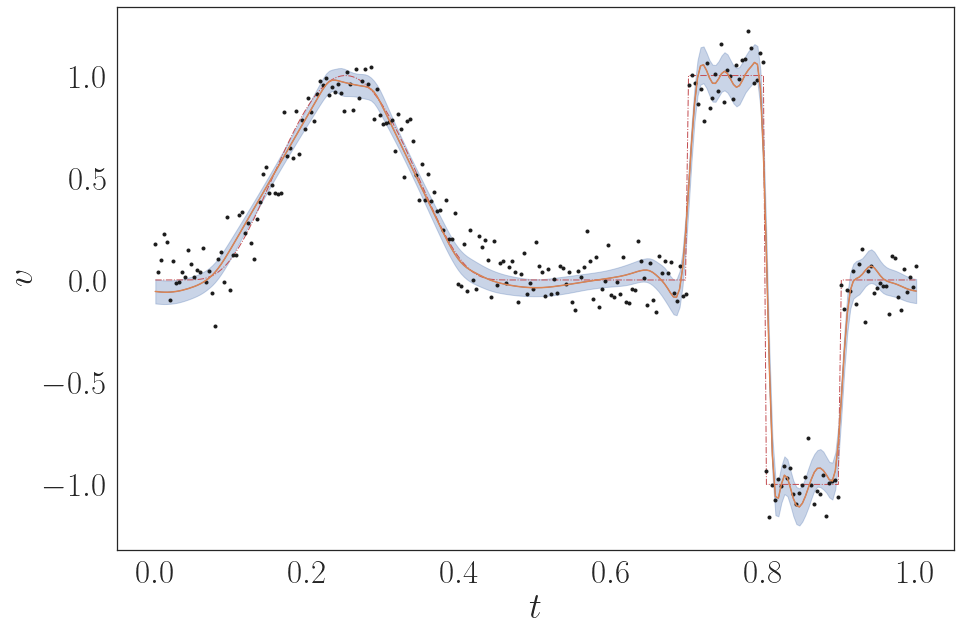

In [317]:
plt.figure(figsize=fig_size)
plt.fill_between(dod.t,v_mean+2*v_std,v_mean-2*v_std, color='b', alpha=.3)
plt.plot(dod.t,v_mean,linewidth=lw)
plt.plot(dod.t,dod.ground_truth,'-.r',linewidth=lw)
plt.plot(dod.t,y_,'.k', markersize = marker_size,linewidth=lw)
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.plot(dod.t,v_mean)

Text(0, 0.5, '$\\ell$')

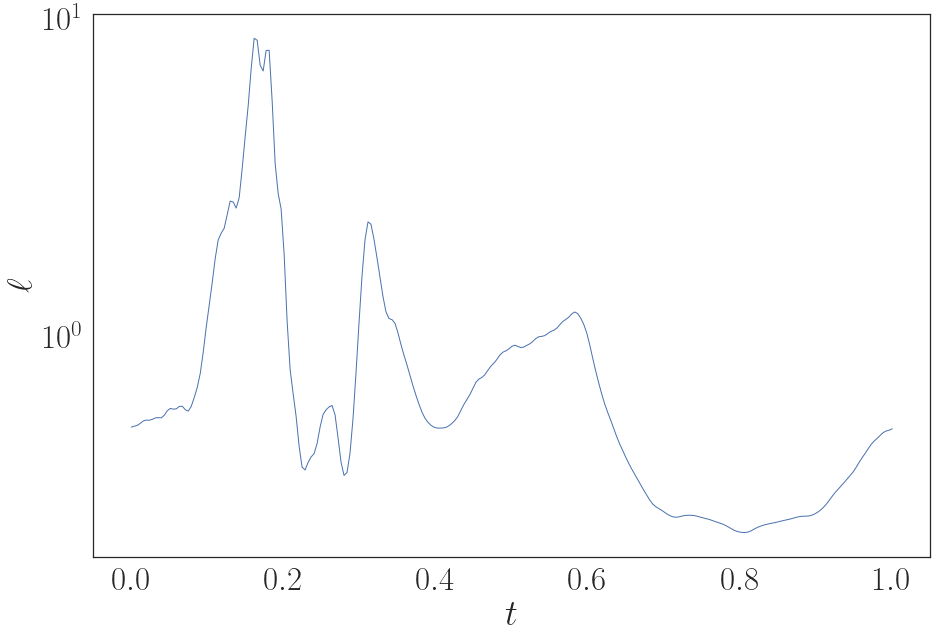

In [318]:
plt.figure(figsize=fig_size)
plt.semilogy(dod.t,np.flip(1/kappa),linewidth=lw)
plt.xlabel('$t$')
plt.ylabel('$\ell$')

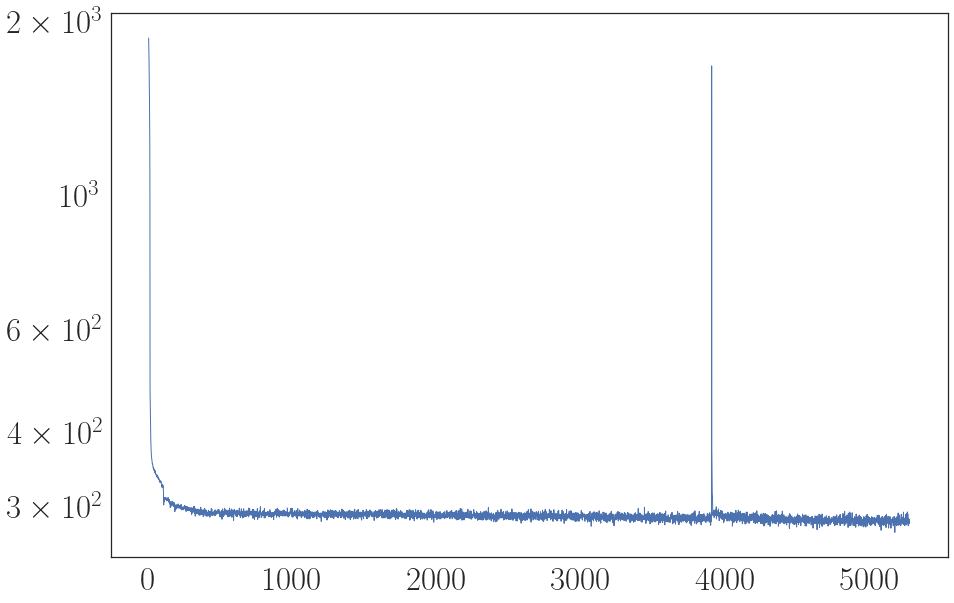

In [319]:
plt.figure(figsize=fig_size)
plt.semilogy(value_hist,linewidth=lw)


In [228]:
mae = metric.mean_absolute(v_mean-dod.ground_truth)
rmse = metric.rmse(v_mean,dod.ground_truth)
psnr = metric.psnr(v_mean,dod.ground_truth)

In [229]:
print('mae = {}, rmse = {}, psnr = {}'.format(mae,rmse,psnr))

mae = 0.04920940846204758, rmse = 0.11267443746328354, psnr = 18.963491439819336
